# MULTIPLE SEQUENCE ALIGNMENT

In [24]:
import new_aligner
import alignment_editing
import retrieve_data_allsp
import importlib
import pandas as pd
import os
import slaver

In [2]:
df = pd.read_csv("/cluster/gjb_lab/2394007/def_data_retrieval/all_anks_allsp_merged.csv") # DATAFRAME CONTAINING OUR SET OF ANNOTATIONS (COMING FROM THE DATABASE INTEGRATION)
wd = "/cluster/gjb_lab/2394007/def_anks_aln/" # DIRECTORY WHERE ALL SEQUENCE AND ALIGNMENT FILES ARE GOING TO BE STORED
if not os.path.isdir(wd):
    os.mkdir(wd)
suf = "anks" # PREFFIX OF REPEAT FAMILY
common_length = 33 # MOST COMMON LENGTH WITHIN THE ANNOTATIONS
conf_db = ["PS50088", "SM00248", "Uniprot", "PF00023", "PR01415", "PF13606"] # LIST CONTAINING ORDER OF PROTEIN SIGNATURE CONFIDENCE

In [3]:
df.origin.value_counts()

PS50088    4118
SM00248    2317
Uniprot     971
PF00023       1
Name: origin, dtype: int64

In [4]:
df

,accession,end,length,repeat_id,source,start,repeat_length,taxonomy_id,species,conf_index,origin
0,Q6FED0,211,418,Q6FED0/178-211,ALL_DBS,178,34,62977,ACIAD,0,PS50088
1,Q06527,60,323,Q06527/31-60,ALL_DBS,31,30,572477,ALLVD,1,SM00248
2,Q06527,96,323,Q06527/64-96,ALL_DBS,64,33,572477,ALLVD,0,PS50088
3,Q06527,129,323,Q06527/97-129,ALL_DBS,97,33,572477,ALLVD,0,PS50088
4,Q06527,162,323,Q06527/130-162,ALL_DBS,130,33,572477,ALLVD,0,PS50088
...,...,...,...,...,...,...,...,...,...,...,...
7402,Q12013,179,749,Q12013/150-179,ALL_DBS,150,30,559292,YEAST,1,SM00248
7403,Q12013,221,749,Q12013/189-221,ALL_DBS,189,33,559292,YEAST,0,PS50088
7404,Q12013,254,749,Q12013/222-254,ALL_DBS,222,33,559292,YEAST,0,PS50088
7405,Q12451,128,1283,Q12451/106-128,ALL_DBS,106,23,559292,YEAST,0,PS50088


## SEQUENTIAL LENGTH AND DATABASE DIRECTED MULTIPLE SEQUENCE ALIGNMENT

In [12]:
new_aligner.guided_alignment3(df, wd, suf, conf_db, common_length, it = 3, t = 16, keep_gappy = False, get_seqs = False, seq_db = "/cluster/gjb_lab/2394007/data/all_species/swissprot_rev.fasta")

clustalo -i /cluster/gjb_lab/2394007/def_anks_aln/seqs/anks_PS50088_33.fasta -t protein -o /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_PS50088_33.sto --outfmt st --threads 16 --force
job submitted
anks_PS50088_33.sto has been created!
Iteration 0
8 3148
2
clustalo -i /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_PS50088_33_gappy.fasta --profile1 /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_PS50088_33_gapless.sto -t protein --is-profile -o /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_PS50088_33_2gapless.sto --outfmt st --threads 16 --force
job submitted
anks_PS50088_33_2gapless.sto has been created!
Iteration 1
1 3155
2
clustalo --profile1 /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_PS50088_33_2gapless_gapless.sto --profile2 /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_PS50088_33_2gapless_gappy.fasta -t protein --is-profile -o /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_PS50088_33_2gapless_2gapless.sto --outfmt st --threads 16 --force
job submitted
anks_PS50088_33

## ALIGNMENT OF "LEFT-OVER" SEQUENCES (POTENTIALLY CONTAINING INSERTIONS/DELETIONS)

In [15]:
aln_dir = os.path.join(wd, "alns")

seq_dir = os.path.join(wd, "seqs")

swissprot = retrieve_data.swissprot_dict("/cluster/gjb_lab/2394007/data/all_species/swissprot_rev.fasta")

all_seqs_path = os.path.join(seq_dir, "anks_allsp.fasta") # PATH TO FILE WHERE ALL SEQUENCES FROM ANNOTATIONS WILL BE WRITTEN

retrieve_data.get_repeat_seqs3(swissprot, df, all_seqs_path) 

missing_ids = alignment_editing.get_missing_seqs(
    os.path.join(aln_dir,"anks_Uniprot_85_2rest_2gapless_2gapless_2gapless_gapless_clean.sto"), # RESULTING ALIGNMENT CONTAINING THE BULK OF THE SEQUENCES
    all_seqs_path,
    write_seqs = True,
    out_file = os.path.join(seq_dir,"unaln_anks_allsp.fasta") # WILL CONTAIN THE SEQUENCES THAT WERE LEFT OUT OF THE ALIGNMENT
                                  )
missing_reps = [missing_id.split("|")[1]+"/"+missing_id.split("/")[-1] for missing_id in missing_ids] # LIST OF REPEAT IDs FROM UNALIGNED SEQUENCES

7407
Alignment has 7214 sequences
There are 7407 sequencesin total
There should be 193 sequences in the output file
7214 7407
193


In [27]:
common_length = 33
t = 8 # NUMBER OF CORES TO RUN CLUSTALO WITH
unaligned_dir = os.path.join(seq_dir, "unaligned")

if not os.path.isdir(unaligned_dir):
    os.mkdir(unaligned_dir)
    
missing_seqs = df[df.repeat_id.isin(missing_reps)] # SUBSETS DATAFRAME SO IT ONLY HAS UNALIGNED REPEAT SEQUENCES ROWS

new_aligner.get_sequences(missing_seqs, "anks_unaln", # PREFFIX TO WRITE ON FASTA FILES
                          unaligned_dir, "/cluster/gjb_lab/2394007/data/all_species/swissprot_rev.fasta") # CREATES ONE FILE PER COMBINATION OF DATABASE OF ORIGIN AND LENGTH

95
Extracted anks_unaln sequences from SM00248 with a length of 33
22
Extracted anks_unaln sequences from SM00248 with a length of 28
8
Extracted anks_unaln sequences from SM00248 with a length of 31
23
Extracted anks_unaln sequences from Uniprot with a length of 31
1
Extracted anks_unaln sequences from Uniprot with a length of 33
16
Extracted anks_unaln sequences from Uniprot with a length of 30
2
Extracted anks_unaln sequences from Uniprot with a length of 29
1
Extracted anks_unaln sequences from Uniprot with a length of 27
1
Extracted anks_unaln sequences from Uniprot with a length of 70
7
Extracted anks_unaln sequences from Uniprot with a length of 32
2
Extracted anks_unaln sequences from Uniprot with a length of 18
3
Extracted anks_unaln sequences from Uniprot with a length of 16
1
Extracted anks_unaln sequences from Uniprot with a length of 66
1
Extracted anks_unaln sequences from Uniprot with a length of 53
1
Extracted anks_unaln sequences from Uniprot with a length of 69
1
Extr

In [20]:
ordered_files = new_aligner.order_seq_files(missing_seqs, "anks_unaln", unaligned_dir, conf_db, common_length)
guide_template = os.path.join(aln_dir,"anks_Uniprot_33_2gapless_2gapless_2gapless_gapless_clean.sto") # FILE CONTAINING GAPLESS ALIGNMENT OF 33-ANKYRIN REPEATS (IT IS THE BEST REFERENCE)
guide_file = new_aligner.generate_random_ids(guide_template, "stockholm", pref = "ref")
start = True
for file in ordered_files: # LOOPS THROUGH FILES CONTAINING UNALIGNED SEQUENCES
    print(new_aligner.get_n_seq(guide_file, "stockholm"))
    seq_sig = file.split('/')[-1].split('.')[0].split('_')[1]
    seq_len = int(file.split('/')[-1].split('_')[-1].split('.')[0])
    print(new_aligner.get_n_seq(file, "fasta"))
    pref, suf = file.split('/')[-1].split(".")
    out_file = os.path.join(aln_dir, pref + "_2guide.sto")
    new_aligner.align_seqs2profile(guide_file, file, out_file, outfmt = 'st', t = t) # SEQUENCES-TO-PROFILE MSA USING CLUSTALO (ALWAYS ALIGN TO THE GUIDE TEMPLATE)
    if start == False:
        outfile_path = os.path.join(aln_dir, pref + "_2rest.sto")
        out_file = new_aligner.align_profile2profile(growing_template, out_file, outfile_path, outfmt = 'st', t = t) # PROFILE-TO-PROFILE ALIGNMENT OF THE NEW ALIGNMENT AND THE GROWING ALIGNMENT
    else:
        start = False
    growing_template = out_file
    growing_template = new_aligner.remove_guides(growing_template, "stockholm") # REMOVES GUIDE SEQUENCES 
    print("GUIDE SEQUENCES REMOVED")
    growing_template = new_aligner.remove_empty_cols(growing_template, "stockholm") # REMOVES EMPTY ALIGNMENT COLUMNS (OCCUPANCY = 0)
    print("EMPTY COLUMNS REMOVED")
    guide_file = new_aligner.generate_random_ids(guide_template, "stockholm") # GENERATES RANDOM IDS FOR THE REFERENCE SEQUENCES
    print(new_aligner.get_n_seq(growing_template, "stockholm"))

3200
1
clustalo --profile1 /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_Uniprot_33_2gapless_2gapless_2gapless_gapless_clean_uuids.sto --profile2 /cluster/gjb_lab/2394007/def_anks_aln/seqs/unaligned/anks_unaln_PS50088_33.fasta -t protein --is-profile -o /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_unaln_PS50088_33_2guide.sto --outfmt st --threads 8 --force
job submitted
anks_unaln_PS50088_33_2guide.sto has been created!
GUIDE SEQUENCES REMOVED
EMPTY COLUMNS REMOVED
3201
3200
95
clustalo -i /cluster/gjb_lab/2394007/def_anks_aln/seqs/unaligned/anks_unaln_SM00248_33.fasta --profile1 /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_Uniprot_33_2gapless_2gapless_2gapless_gapless_clean_uuids.sto -t protein --is-profile -o /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_unaln_SM00248_33_2guide.sto --outfmt st --threads 8 --force
job submitted
anks_unaln_SM00248_33_2guide.sto has been created!
clustalo --profile1 /cluster/gjb_lab/2394007/def_anks_aln/alns/anks_unaln_PS50088_33_2guide_noguid

## REFERENCE GUIDED PROFILE-PROFILE ALIGNMENT

In [23]:
ref_file = "/cluster/gjb_lab/2394007/def_anks_aln/alns/anks_Uniprot_85_2rest_2gapless_2gapless_2gapless_gapless_clean.sto" # MSA RESULTING FROM THE FIRST STEP (CONTAINS BULK OF SEQUENCES: 7214)
target_file = "/cluster/gjb_lab/2394007/def_anks_aln/alns/anks_unaln_Uniprot_85_2rest_noguide_clean.sto" # MSA RESULTING FROM THE SECOND STEP (CONTAINS MINORITY OF SEQUENCES: 193 + REFERENCE)
result_file = "/cluster/gjb_lab/2394007/def_anks_aln/alns/unaln2aln_def3.sto"
slaver.chain_to_ref(ref_file, target_file, result_file) # REFERENCE GUIDED MSA: CONSENSUS COLUMNS ARE ALIGNED. AS ARESULT, COLUMNS CONTAININT INDELS ARE NOT ALIGNED

## RESULTING ALIGNMENT
This is the resulting alignment visualized with Jalview

In [35]:
from IPython.display import Image

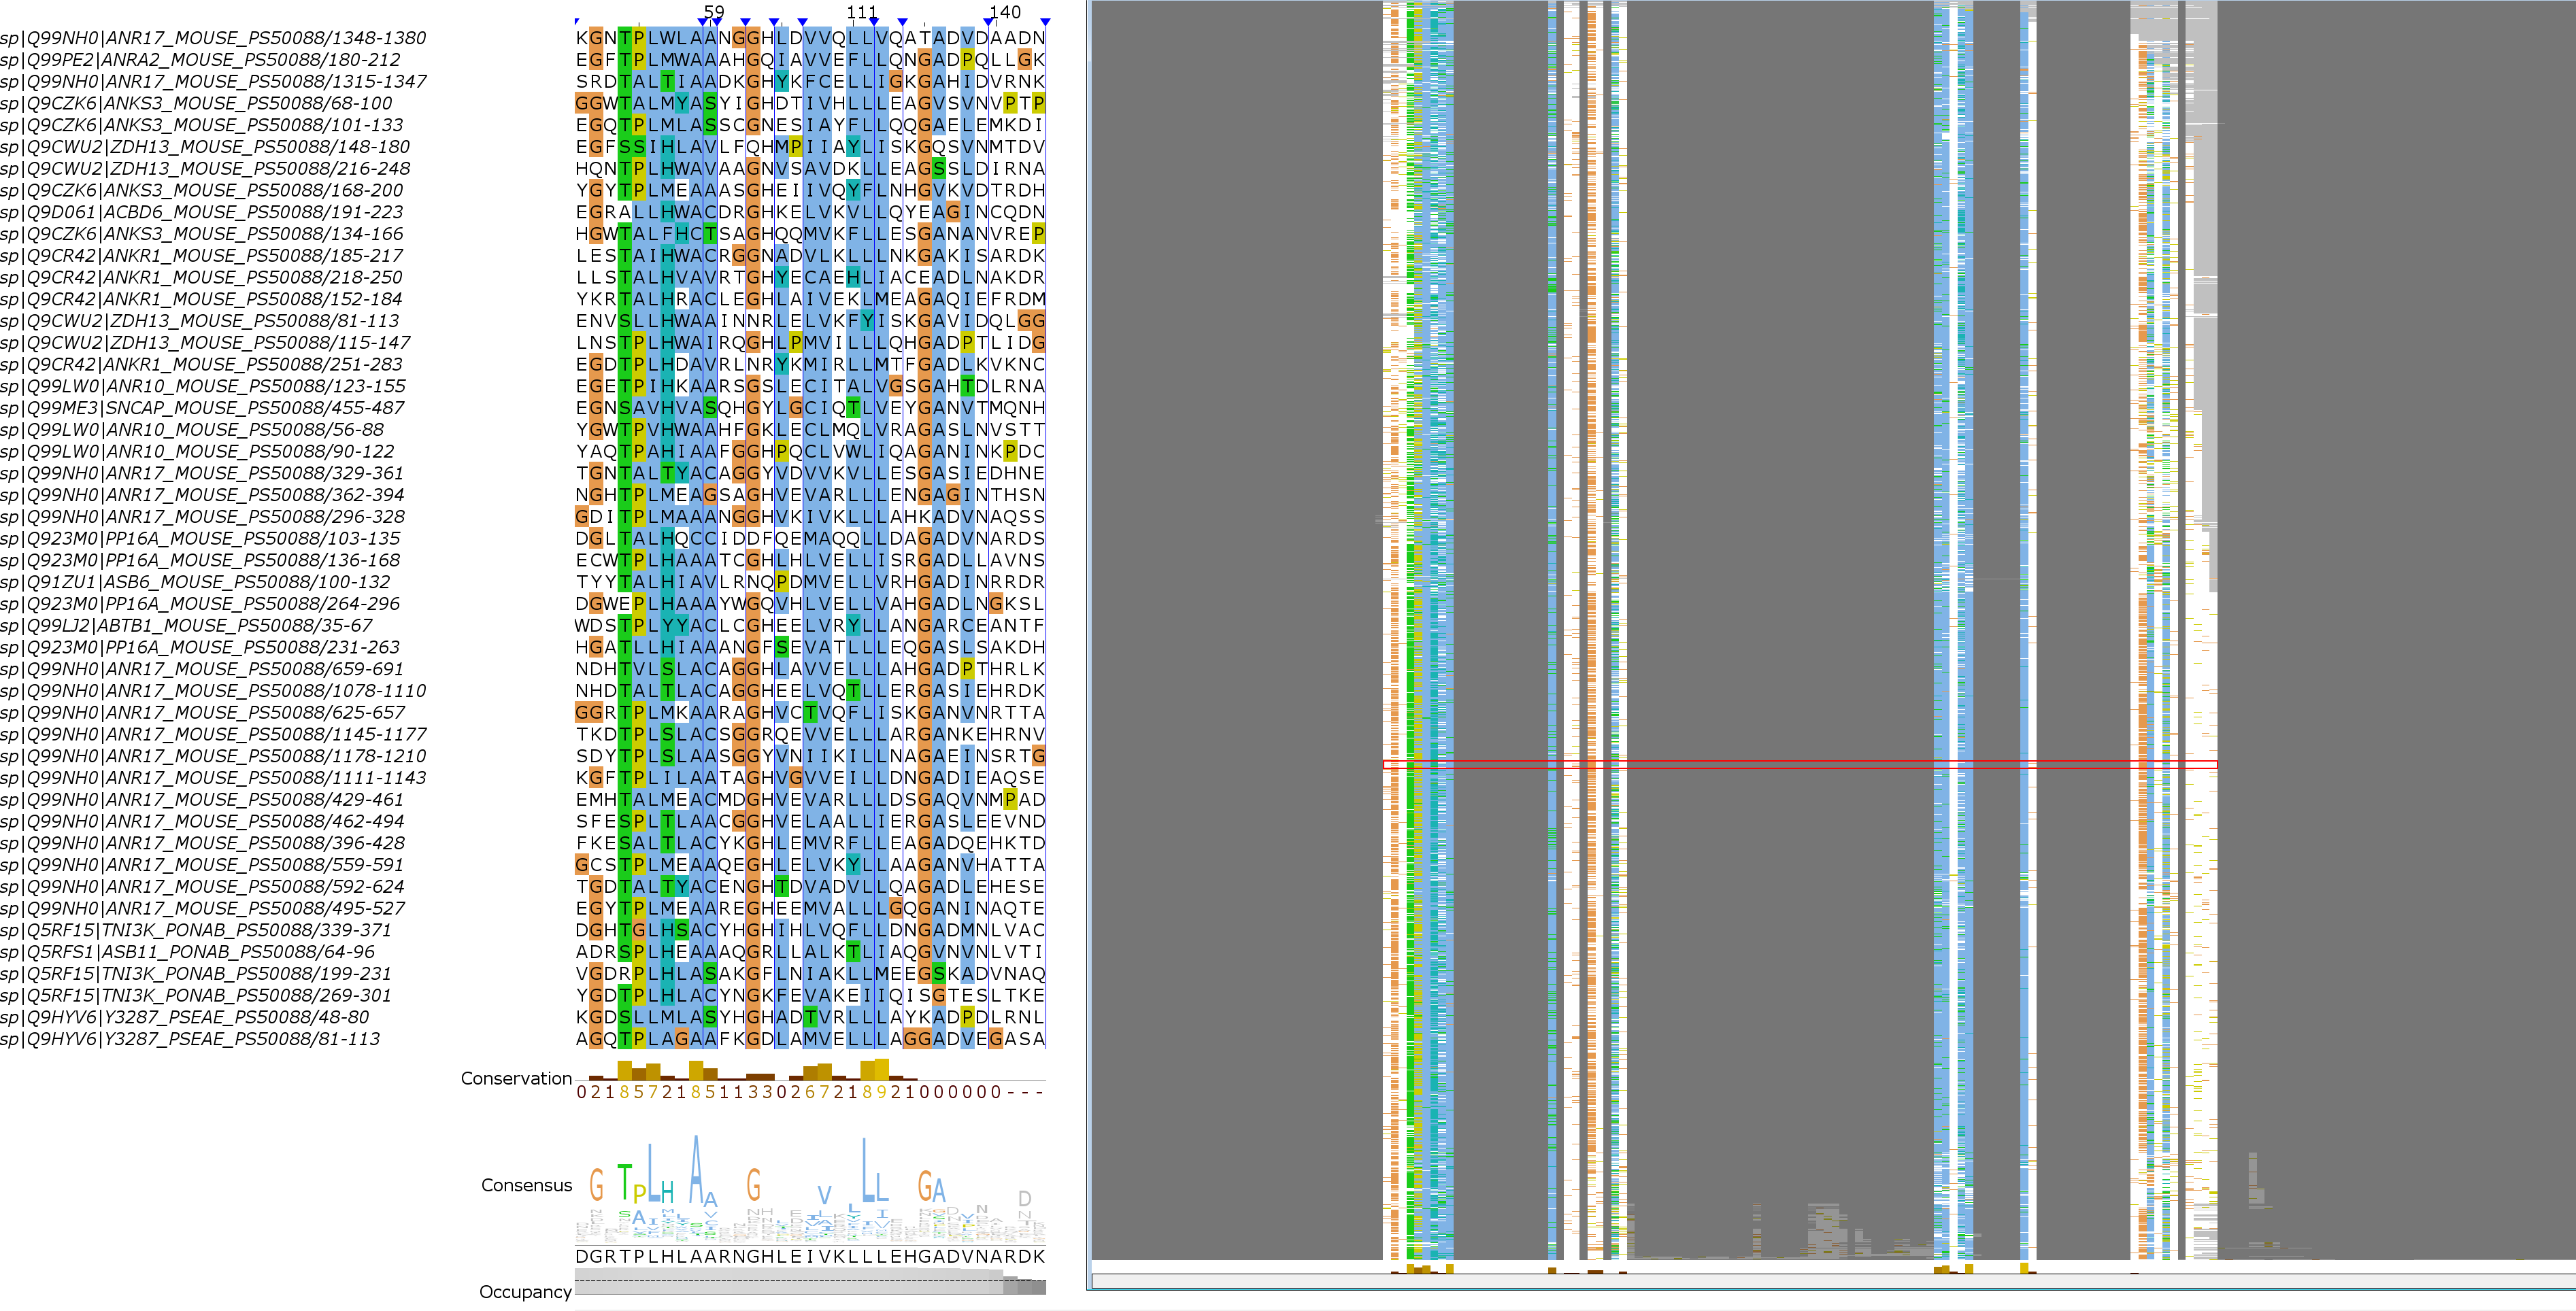

In [29]:
Image(filename="/homes/2394007/ALIGNMENT_OVERVIEW.PNG") 

## FORMATTING THE ALIGNMENT TO RUN VARALIGN

In [33]:
import Bio
import Bio.SeqIO

In [30]:
def format4varalign(aln_in, aln_out, fmt_in = "stockholm"):
    """
    modifies AC field of alignment in stockholm format.
    
    :param aln_in: path of input alignment
    :type aln_in: str, required
    :param aln_out: path of output alignment
    :type aln_in: str, required
    :param fmt_in: input and output MSA format
    :type aln_in: str, defaults to stockholm
    """
    aln = Bio.SeqIO.parse(aln_in, fmt_in)
    recs = []
    for rec in aln:
        rec.annotations["accession"] = rec.id.split("|")[1]
        recs.append(rec)
    Bio.SeqIO.write(recs, aln_out, fmt_in)

In [31]:
varalign_aln = "/cluster/gjb_lab/2394007/def_anks_aln/alns/anks_final_aln.sto"

In [34]:
format4varalign(result_file, varalign_aln) # MODIFY ACC FIELD ON STOCKHOLM MSA FORMAT. IT IS NECESSARY FOR VARALIGN TO PROCESS CORRECTLY THE ALIGNMENT